## **Analyzing Global Sea Level Rise: Trends, Clustering, and Impact Assessment**

In [67]:
# Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

# Modelling
from sklearn.cluster import KMeans
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error




In [72]:
#Load Datasets

# Define file paths
file3 = r"C:\Users\hp\Desktop\Calvin Desktop\Capstone Project  -  Group 8\Data\Climate Change - datasets\Global_sea_level_rise.csv"

# Load CSV files
Global_sea_level = pd.read_csv(file3)



In [74]:
Global_sea_level_1 = Global_sea_level.copy()


In [73]:
Global_sea_level.head()

,year,date,mmfrom1993-2008average
0,1880,07/15/1880,-183.247396
1,1881,07/15/1881,-174.014062
2,1882,07/15/1882,-190.080729
3,1883,07/15/1883,-185.147396
4,1884,07/15/1884,-166.280729


In [57]:
# Check the structure of the datasets
print(Global_sea_level.info(), "\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    143 non-null    int64  
 1   date                    143 non-null    object 
 2   mmfrom1993-2008average  143 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5+ KB
None 



In [55]:
print("Missing values in Global Sea Level Dataset:")
print(Global_sea_level.isnull().sum(), "\n")


Missing values in Global Sea Level Dataset:
year                      0
date                      0
mmfrom1993-2008average    0
dtype: int64 



In [54]:
print(Global_sea_level.describe(), "\n")


             year  mmfrom1993-2008average
count   143.00000              143.000000
mean   1951.00000              -79.729820
std      41.42463               69.902279
min    1880.00000             -190.080729
25%    1915.50000             -138.397396
50%    1951.00000              -87.447396
75%    1986.50000              -25.564062
max    2022.00000               69.660000 



In [53]:
print("Duplicates in Global Sea Level Dataset:", Global_sea_level.duplicated().sum())


Duplicates in Global Sea Level Dataset: 0


2. Global Sea Level Rise Over Time

This will visualize how sea levels have changed over time.

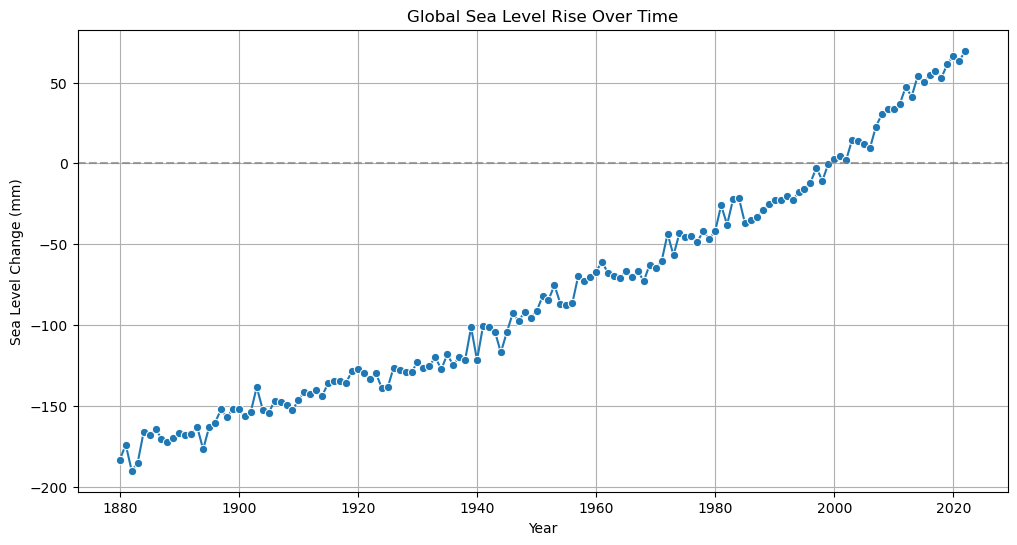

In [61]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=Global_sea_level["year"], y=Global_sea_level["mmfrom1993-2008average"], marker="o", linestyle="-")
plt.axhline(0, color="gray", linestyle="--", alpha=0.7)  # Reference line for 1993-2008 average
plt.xlabel("Year")
plt.ylabel("Sea Level Change (mm)")
plt.title("Global Sea Level Rise Over Time")
plt.grid(True)
plt.show()


## **Trend Analysis**

**Sea Level Rise Overtime: Linear Regression**

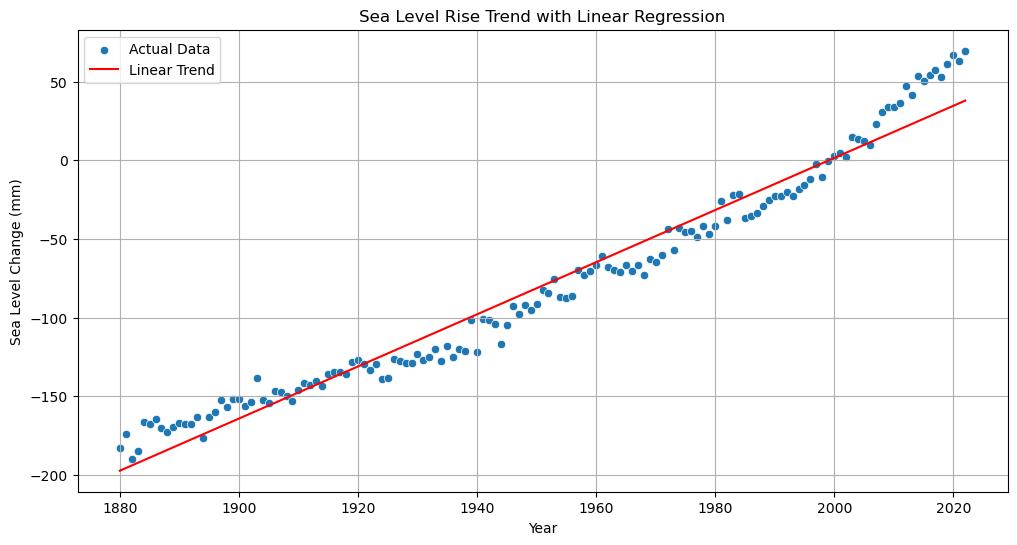

In [62]:
X = Global_sea_level[["year"]]
y = Global_sea_level["mmfrom1993-2008average"]

model = LinearRegression()
model.fit(X, y)

Global_sea_level["predicted"] = model.predict(X)

plt.figure(figsize=(12, 6))
sns.scatterplot(x=Global_sea_level["year"], y=Global_sea_level["mmfrom1993-2008average"], label="Actual Data")
sns.lineplot(x=Global_sea_level["year"], y=Global_sea_level["predicted"], color="red", label="Linear Trend")
plt.xlabel("Year")
plt.ylabel("Sea Level Change (mm)")
plt.title("Sea Level Rise Trend with Linear Regression")
plt.legend()
plt.grid(True)
plt.show()


## **Clustering (K-Means)**

**Identify Patterns in sea level rise across different periods**

c:\Users\hp\anaconda3\envs\learn-env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


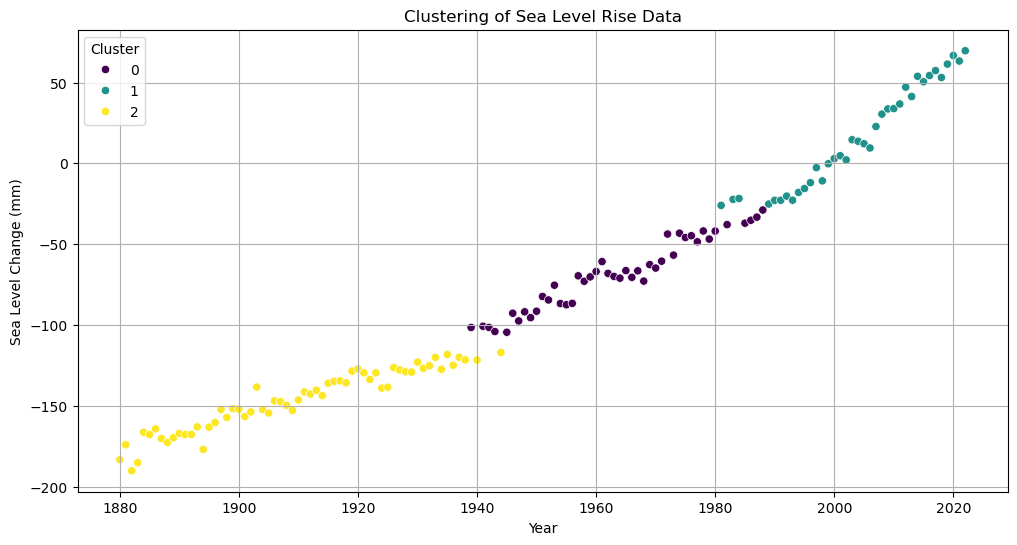

In [63]:
kmeans = KMeans(n_clusters=3, random_state=42)
Global_sea_level["cluster"] = kmeans.fit_predict(Global_sea_level[["mmfrom1993-2008average"]])

plt.figure(figsize=(12, 6))
sns.scatterplot(x=Global_sea_level["year"], y=Global_sea_level["mmfrom1993-2008average"], hue=Global_sea_level["cluster"], palette="viridis")
plt.xlabel("Year")
plt.ylabel("Sea Level Change (mm)")
plt.title("Clustering of Sea Level Rise Data")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


The clustering of sea level rise data in the plot above suggests that the sea level change has followed distinct phases over time. Here are some key insights:

### **1. Three Distinct Phases of Sea Level Change**
The clustering algorithm has grouped the data into three clusters (yellow, purple, and blue), which represent different historical trends in sea level rise.

- **Cluster 2 (Yellow) - Pre-1940:**  
  - Represents the earliest period (before 1940), where sea level change was relatively gradual and stable.  
  - The rate of increase was slow, possibly due to limited human impact on climate during that time.

- **Cluster 0 (Purple) - 1940 to ~1980:**  
  - Marks an increase in the rate of sea level rise compared to the previous period.  
  - This phase could be linked to the start of industrialization’s major impacts on global temperatures, causing glaciers to melt and oceans to warm.

- **Cluster 1 (Blue) - Post-1980 to Present:**  
  - Shows a much steeper increase in sea level rise, indicating acceleration.  
  - This period aligns with increased global warming effects, ice sheet melting, and thermal expansion of seawater.

### **2. Trend Analysis**
- The clustering suggests that sea level rise has not been uniform but has **accelerated over time**, particularly after 1980.
- The steep incline in the blue cluster (post-1980) suggests an **exponential increase** in sea level change, possibly due to rising global temperatures and greenhouse gas emissions.

### **3. Implications**
- The identified clusters reinforce the need for climate action, as recent trends suggest a **rapidly worsening situation**.
- Policymakers and researchers can use such analysis to **predict future acceleration** and **prepare mitigation strategies**.



## **Anomaly Detection**

**Check for unusual changes in sea levels**

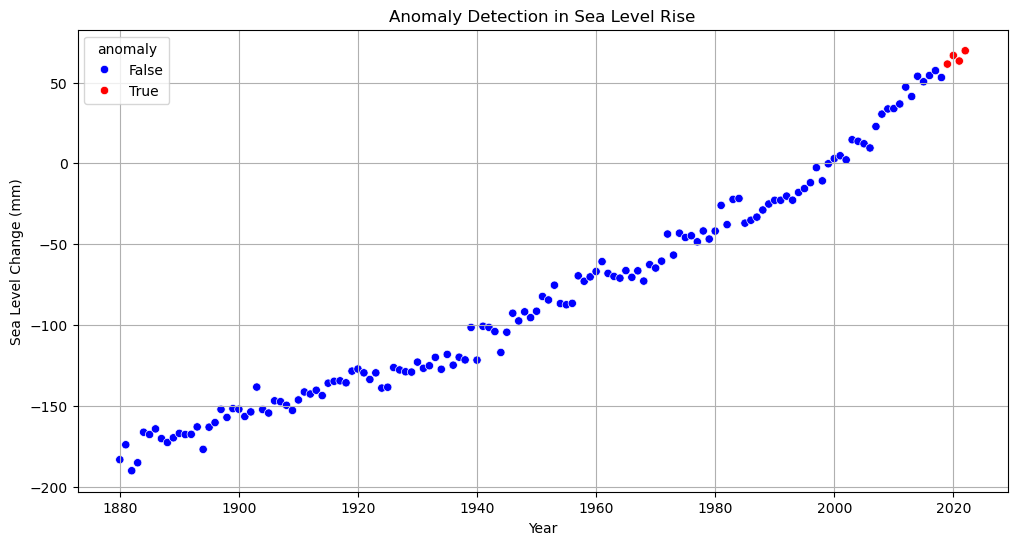

In [65]:
# Calculate Z-score for anomaly detection
Global_sea_level["z_score"] = (Global_sea_level["mmfrom1993-2008average"] - 
                               Global_sea_level["mmfrom1993-2008average"].mean()) / \
                               Global_sea_level["mmfrom1993-2008average"].std()

# Mark anomalies where the absolute Z-score is greater than 2
Global_sea_level["anomaly"] = Global_sea_level["z_score"].abs() > 2  

# Plot anomalies in sea level rise
plt.figure(figsize=(12, 6))
sns.scatterplot(x=Global_sea_level["year"], 
                y=Global_sea_level["mmfrom1993-2008average"], 
                hue=Global_sea_level["anomaly"], 
                palette={False: "blue", True: "red"})

# Labels and title
plt.xlabel("Year")
plt.ylabel("Sea Level Change (mm)")
plt.title("Anomaly Detection in Sea Level Rise")
plt.grid(True)
plt.show()



The anomalies detected between 1980 and the present in sea level rise data could be attributed to several key factors:

### **1. Accelerated Global Warming**  
- Since the 1980s, there has been a significant increase in **global temperatures** due to rising greenhouse gas (GHG) emissions, especially from industrialization, deforestation, and fossil fuel consumption.  
- Higher temperatures lead to more **thermal expansion** of ocean water, contributing to a faster rise in sea levels.

### **2. Ice Sheet and Glacier Melting**  
- The **Greenland and Antarctic ice sheets** have been melting at an accelerated rate since the late 20th century.  
- **Glaciers worldwide** (e.g., in the Himalayas, Alps, and Andes) have also been shrinking, adding to sea level rise.

### **3. Increased Frequency of Extreme Weather Events**  
- More **frequent and intense hurricanes, storms, and typhoons** have caused storm surges, coastal erosion, and flooding, which could influence sea level data.  
- **El Niño events** (which cause temporary spikes in sea level) have been more intense in recent decades.

### **4. Anthropogenic Activities Affecting Coastal Regions**  
- Coastal development and **land subsidence** due to groundwater extraction and urbanization can make sea level rise appear more extreme in certain regions.  
- **Dams and reservoirs** initially slowed sea level rise, but as reservoirs filled up and land use changed, this effect diminished.

### **5. Changes in Ocean Circulation and Climate Feedback Loops**  
- Disruptions in **ocean currents** (e.g., weakening of the Atlantic Meridional Overturning Circulation, AMOC) can lead to irregularities in sea level rise.  
- **Positive feedback loops**, such as the **albedo effect** (less ice means more heat absorption, causing even more melting), have accelerated changes.

### **6. Advancements in Data Collection and Detection Methods**  
- **Satellite measurements (e.g., TOPEX/Poseidon, Jason-1, Jason-2, Jason-3)** since the 1990s have improved accuracy in sea level rise detection.  
- Data anomalies might also reflect improved precision rather than sudden shifts.

### **Summary**  
The anomalies between 1980 and the present likely reflect a **combination of human-induced climate change, ice melt acceleration, extreme weather, and improved measurement techniques**. The last few decades have seen a **dramatic increase in sea level rise rates**, and these anomalies may indicate an even steeper upward trend in the coming years.



## **The ARIMA-based Forecast of Global Sea Level**

c:\Users\hp\anaconda3\envs\learn-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\learn-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\learn-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


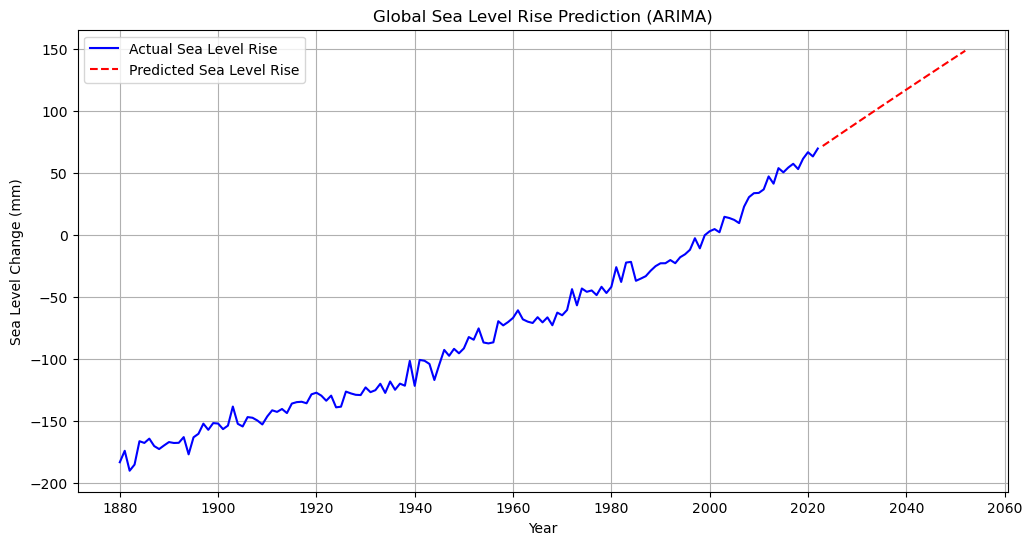

In [75]:

# Ensure year is the index and convert to datetime format
Global_sea_level_1["year"] = pd.to_datetime(Global_sea_level_1["year"], format="%Y")
Global_sea_level_1.set_index("year", inplace=True)

# Fit an ARIMA model (tune order=(p, d, q) for better accuracy)
model = ARIMA(Global_sea_level_1["mmfrom1993-2008average"], order=(2, 1, 2))  
model_fit = model.fit()

# Forecast the next 30 years
future_steps = 30
future_years = [Global_sea_level_1.index[-1] + pd.DateOffset(years=i) for i in range(1, future_steps + 1)]
forecast = model_fit.forecast(steps=future_steps)

# Convert forecast to a Pandas Series with correct index
forecast_series = pd.Series(forecast, index=pd.to_datetime(future_years))

# Plot historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(Global_sea_level_1.index, Global_sea_level_1["mmfrom1993-2008average"], label="Actual Sea Level Rise", color="blue")
plt.plot(forecast_series.index, forecast_series, label="Predicted Sea Level Rise", color="red", linestyle="dashed")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Sea Level Change (mm)")
plt.title("Global Sea Level Rise Prediction (ARIMA)")
plt.legend()
plt.grid(True)
plt.show()


The ARIMA-based forecast of global sea level rise suggests a continued and accelerating increase beyond 2020. The trend shown in the historical data aligns with real-world observations of rising sea levels due to climate change.

### **Key Insights from the Prediction**:
1. **Consistent Upward Trend** – The data shows that sea levels have been rising steadily since the late 19th century, with an increasing rate in recent decades.
2. **Projected Acceleration** – The red dashed line indicates that if current trends continue, sea levels will continue to rise significantly, potentially reaching 150mm above the baseline by 2050.
3. **Climate Change Impact** – This rise is largely attributed to global warming, causing:
   - **Glacial and Ice Sheet Melting** – Particularly in Greenland and Antarctica.
   - **Thermal Expansion** – As ocean water warms, it expands.
   - **Increased Coastal Flooding & Erosion** – More frequent and severe flooding events, leading to displacement and habitat loss.


If sea levels continue to rise significantly above the baseline, the world will undergo drastic changes, affecting multiple aspects of life. Below is an overview of how different sectors will be impacted:

---

## **How the World Will Look with Rising Sea Levels**

---

## **Economic Impact**
🔹 **Loss of Infrastructure & Property Damage**  
   - Coastal cities like **New York, Mumbai, Jakarta, and London** will face severe flooding, leading to billions in damages.
   - Ports, airports, and industrial zones will be at risk, disrupting trade.
   - Insurance costs will **skyrocket**, with rising premiums for flood-prone areas.
  
🔹 **Displacement & Job Loss**  
   - Fishing, tourism, and real estate industries will suffer.
   - Coastal farms and industries will relocate, causing **mass unemployment** in affected areas.
   - **Rural-to-urban migration** will strain inland cities.

🔹 **Agriculture & Food Security**  
   - **Saltwater intrusion** will destroy fertile land, reducing global crop yields.
   - Fisheries will collapse as **ocean acidification** and changing currents disrupt marine ecosystems.

---

## **Health Impacts**
🔹 **Waterborne Diseases**  
   - Flooding increases **cholera, malaria, dengue, and typhoid** outbreaks.
   - Standing water leads to mosquito breeding, spreading **Zika and malaria**.

🔹 **Heat Stress & Respiratory Issues**  
   - Rising temperatures worsen **heat strokes, respiratory diseases**, and cardiovascular problems.
   - **Air pollution from wildfires** will intensify, affecting millions.

🔹 **Mental Health Crisis**  
   - Climate refugees will experience **anxiety, PTSD, and depression** due to displacement and loss of homes.

---

## **Demographic & Social Life Changes**
🔹 **Mass Migration (Climate Refugees)**  
   - **Over 1 billion people** could be displaced by 2050, leading to resource conflicts.
   - Small island nations (Maldives, Tuvalu, Kiribati) may become **uninhabitable**.
   - Inland areas will face **overpopulation, housing crises, and social unrest**.

🔹 **Cultural Heritage Loss**  
   - Historical sites like Venice, Machu Picchu, and the Great Pyramids could be endangered.
   - Indigenous communities relying on coastal ecosystems will **lose their way of life**.

---

## **Urban Planning Challenges**
🔹 **Redesigning Cities for Rising Waters**  
   - Countries will need **floating cities, seawalls, and elevated infrastructure** (e.g., Netherlands’ flood-resistant designs).
   - Underground transportation systems like **subways and tunnels will become obsolete** in some cities.
   - Governments will need to **relocate entire populations**, requiring massive funding.

🔹 **Costly Adaptation Efforts**  
   - Billions of dollars will be spent on **drainage systems, water barriers, and artificial islands**.
   - Some cities will need to **abandon low-lying areas**, leading to financial losses.

---

## **Weather & Climate Impact**
🔹 **More Extreme Storms & Hurricanes**  
   - Warmer oceans fuel **super typhoons and hurricanes**, leading to catastrophic flooding.
   - Wind patterns will shift, increasing droughts in some areas and heavy rains in others.

🔹 **Longer & More Intense Heatwaves**  
   - Higher temperatures will disrupt **agriculture, power grids, and water supplies**.
   - Wildfires will worsen, destroying millions of acres annually.

🔹 **Disrupted Ocean Currents**  
   - The melting Arctic could weaken the **Atlantic Meridional Overturning Circulation (AMOC)**, disrupting global weather.
   - Areas reliant on monsoons (India, Southeast Asia) may face **unpredictable rainfall**.

---

## **The Urgent Need for Action**
Sea level rise is not a distant threat—it is happening **now**. Governments, businesses, and individuals must **invest in climate resilience**, reduce carbon emissions, and prepare for an era of change. 

